# Challenge Scratchbook

* This notebook explores methods for the Kernel Methods for Machine Learning Kaggle [challenge](https://www.kaggle.com/c/kernel-methods-for-machine-learning-2018-2019/data).

* Note that this is a binary classification challenge.

Our first goal is to implement two baseline methods:
1. Random classification
2. All instances are 0s (Doing so we get an idea of the proportion of 0's in the public test set)
3. Implement the Simple Pattern Recognition Algorithm (SPR) from Learning with Kernels 

Before that, we have to implement some data loaders

## Imports

In [1]:
import csv
import os
import numpy as np
from scipy import optimize
from itertools import product
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

## Paths and Globals

In [2]:
CWD = os.getcwd()
DATA_DIR = os.path.join(CWD, "data")
RESULT_DIR = os.path.join(CWD, "results")

FILES = {0: {"train_mat": "Xtr0_mat100.csv",
             "train": "Xtr0.csv",
             "test_mat": "Xte0_mat100.csv",
             "test": "Xte0.csv",
             "label": "Ytr0.csv"},
         1: {"train_mat": "Xtr1_mat100.csv",
             "train": "Xtr1.csv",
             "test_mat": "Xte1_mat100.csv",
             "test": "Xte1.csv",
             "label": "Ytr1.csv"},
         2: {"train_mat": "Xtr2_mat100.csv",
             "train": "Xtr2.csv",
             "test_mat": "Xte2_mat100.csv",
             "test": "Xte2.csv",
             "label": "Ytr2.csv"}}

## 0 entries

In [3]:
#with open(os.path.join(RESULT_DIR, "results.csv"), 'w', newline='') as csvfile:
 #   writer = csv.writer(csvfile, delimiter=',')
    
  #  writer.writerow(["Id", "Bound"])
   # for i in range(3000):
    #    writer.writerow([i, 0])

**Comment:**

* We get 0.51266 which means that the dataset is pretty balanced.

## SPR: A Simple Pattern Recognition Algorithm

In [4]:
class SPR:
    """
    This class implements the Simple Pattern Recognition algorithm found in the Learning with Kernel books
    """
    def __init__(self,c, kernel=False):
        self.m0 = 0
        self.m1 = 0
        self.b = 0
        self.c = c
        self.kernel = kernel


        
    def fit(self,X,y):
        """
        Fitting phase
        
        Parameters
        ------------
        - X : numpy.ndarray
            Data matrix
            
        - y : numpy.array
            Labels
        """
        
        self.X_train = X
        self.X0 = X[y == 0]
        self.X1 = X[y == 1]
        
        self.m0 = len(self.X0)
        self.m1 = len(self.X1)
        
        if self.kernel == False:
            self.b = 1/2 * (1/(self.m0**2)*np.sum(self.X0.dot(self.X0.T)) - 1/(self.m1**2)*np.sum(self.X1.dot(self.X1.T)))
        else:
            # à changer (comment ?)
            self.list0 = list(np.where(y==0)[0])
            self.list1 = list(np.where(y==1)[0])
            self.b = 1/2 * (1/(self.m0**2)*np.sum([self.kernel(self.X_train[i],self.X_train[j],self.c) for i in self.list0 for j in self.list0]) - (1/(self.m1**2))*np.sum([self.kernel(self.X_train[i],self.X_train[j],self.c) for i in self.list1 for j in self.list1]))

    
    def predict(self,X):
        
        y_pred = np.zeros(len(X))
        
        for i in range(len(X)):
            if self.kernel == False:
                val = (1 / self.m1) * np.sum(self.X1.dot(X[i])) - (1 / self.m0) * np.sum(self.X0.dot(X[i])) + self.b
            else:
                val = ((1/self.m1)*np.sum([kernel(self.X_train[k],X[i],self.c) for k in self.list1]) 
                       - (1/self.m0)*np.sum([kernel(self.X_train[k],X[i],self.c) for k in self.list0])) + self.b                    
            y_pred[i] = np.sign(val)/2 + 1/2
        return y_pred    
    
    
    def score(self, y, y_pred):
        return np.sum([y == y_pred]) / len(y)
    

## Data loading refactoring

In [5]:
def load_data(file_id, mat=True):
    
    X_train = list()
    Y_train = list()
    X_test = list()
    
    dic = FILES[file_id]
    
    if mat:
        files = [dic["train_mat"], dic["label"], dic["test_mat"]]
    else:
        files = [dic["train"], dic["label"], dic["test"]]

    for file, l in zip(files, [X_train, Y_train, X_test]):
        with open(os.path.join(DATA_DIR, file), "r", newline="") as csvfile:
            if "mat" in file:
                reader = csv.reader(csvfile, delimiter=" ")
                for row in reader:
                    l.append(row)
            else:
                reader = csv.reader(csvfile, delimiter=",")
                next(reader, None) # Skip the header
                for row in reader:
                    l.append(row[1])
                
    if mat:
        X_train = np.array(X_train).astype("float")
        Y_train = np.array(Y_train).astype("int")
        X_test = np.array(X_test).astype("float")
        np.random.seed(0)
        index = np.random.permutation(len(X_train))
        X_train = X_train[index]
        Y_train = Y_train[index]
    
    else:
        np.random.seed(0)
        index = np.random.permutation(len(X_train))
        X_train = [X_train[i] for i in index]
        Y_train = [Y_train[i] for i in index]
        Y_train = np.array(Y_train).astype("int")
        
    
    return X_train, Y_train, X_test

## Define Kernels

In [6]:
def pol_kernel(x,y,c): #c=0
    return (x.dot(y) + c)**2

def gaussian_kernel(x,y, gamma): #c=100
    return np.exp(-gamma*np.linalg.norm(x-y)**2)

def linear_kernel(x,y,c): 
    return x.dot(y)

## Train and test on the different sets

In [7]:
results = np.zeros(3000)
kernel = False

for i in range(len(FILES)):
    X_train, Y_train, X_test = load_data(i)
    X_val = X_train[1600:]
    Y_val = Y_train[1600:]
    X_train = X_train[:1600]
    Y_train = Y_train[:1600]
    clf = SPR(10, kernel)
    clf.fit(X_train, Y_train)
    y_pred_train =clf.predict(X_train)
    y_pred_val = clf.predict(X_val)
    y_pred_test = clf.predict(X_test)
    
    score_train = clf.score(y_pred_train, Y_train)
    score_val = clf.score(y_pred_val, Y_val)
    results[i*1000:i*1000 + 1000] = y_pred_test
    print(f"Accuracy on train set / val set {i} : {score_train} / {score_val}")



Accuracy on train set / val set 0 : 0.5825 / 0.5375
Accuracy on train set / val set 1 : 0.64 / 0.5975
Accuracy on train set / val set 2 : 0.605625 / 0.5475


**Produit scalaire:**
- Accuracy on train set / val set 0 : 0.563125 / 0.5175
- Accuracy on train set / val set 1 : 0.65125 / 0.605
- Accuracy on train set / val set 2 : 0.58625 / 0.6325

**Noyau carré (<.,.>²):**


**Noyau Gaussien:**

## Train and test on the whole set

In [31]:
n = 2000
len_val = 0
len_train = n - len_val
all_X_train = np.zeros((3*len_train,100))
all_Y_train = np.zeros(3*len_train)
all_X_val = np.zeros((3*len_val,100))
all_Y_val = np.zeros(3*len_val)
all_X_test = np.zeros((3000,100))


kernel = False
for i in range(len(FILES)):
    X_train, Y_train, X_test = load_data(i)
    X_val = X_train[len_train:]
    Y_val = Y_train[len_train:]
    X_train = X_train[:len_train]
    Y_train = Y_train[:len_train]
    all_X_train[i*len_train:i*len_train + len_train] = X_train
    all_Y_train[i*len_train:i*len_train + len_train] = Y_train
    all_X_val[i*len_val:i*len_val + len_val] = X_val
    all_Y_val[i*len_val:i*len_val + len_val] = Y_val
    all_X_test[i*1000:i*1000 + 1000] = X_test
    
clf = SPR(50, kernel)
clf.fit(all_X_train, all_Y_train)
y_pred_train =clf.predict(all_X_train)
y_pred_val = clf.predict(all_X_val)
y_pred_test = clf.predict(all_X_test)
score_train = clf.score(y_pred_train, all_Y_train)
score_val = clf.score(y_pred_val, all_Y_val)
print(f"Accuracy on train set / val set {i} : {score_train} / {score_val}")

Accuracy on train set / val set 2 : 0.5735 / nan


C:\Users\luc_b\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in long_scalars


**Produit scalaire:**
- Accuracy on train set / val set 2 : 0.5741666666666667 / 0.5716666666666667


**Noyau carré (<.,.>²):**
  - Accuracy on train set / val set 2 : 0.5741666666666667 / 0.5716666666666667 $(c=0)$
  
**Noyau Gaussien:**
- Accuracy on train set / val set 2 : 0.6504166666666666 / 0.57 $(\gamma = 100)$
- Accuracy on train set / val set 2 : 0.5702083333333333 / 0.5691666666666667 $(\gamma = 10)$
- Accuracy on train set / val set 2 : 0.5889583333333334 / 0.5725 $(\gamma = 50)$

## SVM

In [23]:
A = np.matrix([[1.,0.],[0.,1.]])
np.fill_diagonal(A, np.diagonal(A)/2)
A

matrix([[0.5, 0. ],
        [0. , 0.5]])

In [24]:
class SVM:
    """
    This class implements the Support Vector Machine algorithm
    """
    def __init__(self, c, λ, kernel=False):
        self.kernel = kernel
        self.c = c
        self.λ = λ
        self.n = 0

        
    def fit(self,X,y):
        """
        Fitting phase
        
        Parameters
        ------------
        - X : numpy.ndarray
            Data matrix
            
        - y : numpy.array
            Labels
        """
        
        self.X_train = X
        
        # Define the kernel matrix K
        K = np.zeros((len(X_train),len(X_train)))
        
        for j in tqdm_notebook(range(len(X_train))):
            for i in range(j+1):
                K[i,j] = kernel(X_train[i], X_train[j],self.c)
        K =  K + K.T
        np.fill_diagonal(K, np.diagonal(K)/2)

        
        
        # transpose Y_train to fit the optimization formulation
        y = Y_train * 2 - 1
        
        # Use scipy.optimize to solve the problem
        self.n = len(y)

        # Define the loss function
        f = lambda x: 1/2 * x.T.dot(K).dot(x) - y.T.dot(x) 
        
        # Define the jacobian of the loss function
        grad_f = lambda x: K.dot(x) - y

        # Define the bounds (sequences of min, max) (This depends on the sign of Y_train)
        bounds = [[0, y[i] / (2 * self.n * self.λ)] 
                  if y[i] > 0 
                  else [y[i] / (2 * self.n * self.λ), 0] 
                  for i in range(self.n)]

        # define initial point
        x0 = np.zeros(self.n)
        
        # define number max iteration
        #opts = {"maxiter": 15000}
        opts = {"maxiter": 100}
        
        # optimize
        res = optimize.minimize(f, x0, jac=grad_f, bounds=bounds, method="L-BFGS-B", options=opts)
                
        # save results
        self.α = res["x"]
        
    def predict(self,X):
        
        y_pred = np.zeros(len(X))
        
        for i in tqdm_notebook(range(len(X))):
            if self.kernel == False:
                return "you have to define a kernel"
            else:
                val = np.sum([self.α[j] * self.kernel(self.X_train[j], X[i], self.c) for j in range(self.n)])
                
            y_pred[i] = np.sign(val)/2 + 1/2
            
        return y_pred    
    
    
    def score(self, y, y_pred):
        return np.sum([y == y_pred]) / len(y)
    

## Train and test on the different sets

In [25]:
results = np.zeros(3000)

kernel = gaussian_kernel

γ = 10
λ = 1e-4

for i in range(len(FILES)):
    X_train, Y_train, X_test = load_data(i)
    X_val = X_train[1600:]
    Y_val = Y_train[1600:]
    X_train = X_train[:1600]
    Y_train = Y_train[:1600]
    clf = SVM(γ, λ, kernel)
    clf.fit(X_train, Y_train)
    y_pred_train =clf.predict(X_train)
    y_pred_val = clf.predict(X_val)
    y_pred_test = clf.predict(X_test)
    
    score_train = clf.score(y_pred_train, Y_train)
    score_val = clf.score(y_pred_val, Y_val)
    results[i*1000:i*1000 + 1000] = y_pred_test
    print(f"Accuracy on train set / val set {i} : {score_train} / {score_val}")


[[2.         0.89066714 0.82385411 ... 0.88020606 0.77659559 0.82190968]
 [0.89066714 2.         0.81417776 ... 0.93156578 0.76025446 0.78397061]
 [0.82385411 0.81417776 2.         ... 0.82971504 0.79893143 0.84156227]
 ...
 [0.88020606 0.93156578 0.82971504 ... 2.         0.7747627  0.80651857]
 [0.77659559 0.76025446 0.79893143 ... 0.7747627  2.         0.9098114 ]
 [0.82190968 0.78397061 0.84156227 ... 0.80651857 0.9098114  2.        ]]
[[1.         0.89066714 0.82385411 ... 0.88020606 0.77659559 0.82190968]
 [0.89066714 1.         0.81417776 ... 0.93156578 0.76025446 0.78397061]
 [0.82385411 0.81417776 1.         ... 0.82971504 0.79893143 0.84156227]
 ...
 [0.88020606 0.93156578 0.82971504 ... 1.         0.7747627  0.80651857]
 [0.77659559 0.76025446 0.79893143 ... 0.7747627  1.         0.9098114 ]
 [0.82190968 0.78397061 0.84156227 ... 0.80651857 0.9098114  1.        ]]



Accuracy on train set / val set 0 : 0.678125 / 0.57


KeyboardInterrupt: 

## Tuning 

In [44]:
γ = 500
λ = 5e-5
gamma_list = np.linspace(300,γ,3, endpoint = True)
lambda_list = np.linspace(1e-5, λ, 2, endpoint = True)
settings = list(product(gamma_list,lambda_list))
best_score = {i: 0 for i in range(3)}
best_lambda = {i: 0 for i in range(3)}
best_gamma = {i: 0 for i in range(3)}

for k, tup in enumerate(settings):
    γ, λ = tup
    
    len_files = len(FILES)
    for i in range(len_files):
        X_train, Y_train, X_test = load_data(i)
        X_val = X_train[1600:]
        Y_val = Y_train[1600:]
        X_train = X_train[:1600]
        Y_train = Y_train[:1600]
        clf = SVM(γ, λ, kernel)
        clf.fit(X_train, Y_train)
        y_pred_train =clf.predict(X_train)
        y_pred_val = clf.predict(X_val)
        score_train = clf.score(y_pred_train, Y_train)
        score_val = clf.score(y_pred_val, Y_val)
        
        if score_val > best_score[i]:
            best_score[i] = score_val
            best_lambda[i] = λ
            best_gamma[i] = γ
            
        print(f"Accuracy on train set / val set {i} : {score_train} / {score_val} (λ: {λ},γ: {γ})")
        
    print('\n')
        
print(f"score : {best_score}")
print(f"lambda : {best_lambda}")
print(f"gamma : {best_gamma}")

Accuracy on train set / val set 0 : 1.0 / 0.5575 (λ: 1e-05,γ: 300.0)
Accuracy on train set / val set 1 : 1.0 / 0.745 (λ: 1e-05,γ: 300.0)
Accuracy on train set / val set 2 : 1.0 / 0.6325 (λ: 1e-05,γ: 300.0)


Accuracy on train set / val set 0 : 1.0 / 0.5575 (λ: 5e-05,γ: 300.0)
Accuracy on train set / val set 1 : 1.0 / 0.745 (λ: 5e-05,γ: 300.0)
Accuracy on train set / val set 2 : 1.0 / 0.6325 (λ: 5e-05,γ: 300.0)


Accuracy on train set / val set 0 : 1.0 / 0.5775 (λ: 1e-05,γ: 400.0)
Accuracy on train set / val set 1 : 1.0 / 0.7425 (λ: 1e-05,γ: 400.0)
Accuracy on train set / val set 2 : 1.0 / 0.6275 (λ: 1e-05,γ: 400.0)


Accuracy on train set / val set 0 : 1.0 / 0.5775 (λ: 5e-05,γ: 400.0)
Accuracy on train set / val set 1 : 1.0 / 0.7425 (λ: 5e-05,γ: 400.0)
Accuracy on train set / val set 2 : 1.0 / 0.6275 (λ: 5e-05,γ: 400.0)


Accuracy on train set / val set 0 : 1.0 / 0.575 (λ: 1e-05,γ: 500.0)
Accuracy on train set / val set 1 : 1.0 / 0.7275 (λ: 1e-05,γ: 500.0)
Accuracy on train set / val s

1er lancement:
- score : {0: 0.6, 1: 0.6775, 2: 0.6425}
- lambda : {0: 0.0002575, 1: 1e-05, 2: 0.000505}
- gamma : {0: 77.5, 1: 100.0, 2: 32.5}

2ème lancement:
- score : {0: 0.61, 1: 0.7075, 2: 0.6425}
- lambda : {0: 5.5e-05, 1: 1e-05, 2: 1e-05}
- gamma : {0: 70.0, 1: 300.0, 2: 300.0}

3ème lancement:
- score : {0: 0.6075, 1: 0.73, 2: 0.66}
- lambda : {0: 1e-05, 1: 1e-05, 2: 1e-05}
- gamma : {0: 350.0, 1: 400.0, 2: 500.0}

4ème lancement:
- score : {0: 0.59, 1: 0.73, 2: 0.6575}
- lambda : {0: 5e-06, 1: 5e-06, 2: 5e-06}
- gamma : {0: 400.0, 1: 400.0, 2: 400.0}

5ème lancement ! :
- score : {0: 0.59, 1: 0.73, 2: 0.6575}
- lambda : {0: 5e-05, 1: 5e-05, 2: 5e-05}
- gamma : {0: 400.0, 1: 400.0, 2: 400.0}

6ème lancement (après shuffle):
- score : {0: 0.5775, 1: 0.745, 2: 0.6375}
- lambda : {0: 1e-05, 1: 1e-05, 2: 1e-05}
- gamma : {0: 400.0, 1: 300.0, 2: 500.0}


**Choose $\gamma = 400$ and $\lambda = 1e-5$ for the three sets**

In [47]:
results = np.zeros(3000)

kernel = gaussian_kernel

γ = 400
λ = 1e-5
len_val =  0
len_train = 2000 - len_val

for i in range(len(FILES)):
    X_train, Y_train, X_test = load_data(i)
    X_val = X_train[len_train:]
    Y_val = Y_train[len_train:]
    X_train = X_train[:len_train]
    Y_train = Y_train[:len_train]
    clf = SVM(γ, λ, kernel)
    clf.fit(X_train, Y_train)
    y_pred_train =clf.predict(X_train)
    y_pred_val = clf.predict(X_val)
    y_pred_test = clf.predict(X_test)
    
    score_train = clf.score(y_pred_train, Y_train)
    score_val = clf.score(y_pred_val, Y_val)
    results[i*1000:i*1000 + 1000] = y_pred_test
    print(f"Accuracy on train set / val set {i} : {score_train} / {score_val}")

C:\Users\luc_b\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in long_scalars


Accuracy on train set / val set 0 : 1.0 / nan
Accuracy on train set / val set 1 : 1.0 / nan
Accuracy on train set / val set 2 : 1.0 / nan


**Choose different $\gamma$ and $\lambda$ for the three sets**

In [49]:
results = np.zeros(3000)

kernel = gaussian_kernel

γ = [400, 300, 500]
λ = [1e-5,1e-5,1e-5]
len_val =  0
len_train = 2000 - len_val

for i in range(len(FILES)):
    X_train, Y_train, X_test = load_data(i)
    X_val = X_train[len_train:]
    Y_val = Y_train[len_train:]
    X_train = X_train[:len_train]
    Y_train = Y_train[:len_train]
    clf = SVM(γ[i], λ[i], kernel)
    clf.fit(X_train, Y_train)
    y_pred_train =clf.predict(X_train)
    y_pred_val = clf.predict(X_val)
    y_pred_test = clf.predict(X_test)
    
    score_train = clf.score(y_pred_train, Y_train)
    score_val = clf.score(y_pred_val, Y_val)
    results[i*1000:i*1000 + 1000] = y_pred_test
    print(f"Accuracy on train set / val set {i} : {score_train} / {score_val}")

C:\Users\luc_b\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in long_scalars


Accuracy on train set / val set 0 : 1.0 / nan
Accuracy on train set / val set 1 : 1.0 / nan
Accuracy on train set / val set 2 : 1.0 / nan


## Kernel PCA

In [241]:
def PCA(K):
    """This function implement the Kernel PCA
    
    Parameters
    ------------
    - K : numpy.ndarray
        Gram matrix
    """
    
    n = np.shape(K)[0]
    
    # 1) Center the Gram matrix
    U = (1/n)*np.ones((n,n))
    I = np.eye(n)
    Kc =  (I-U).dot(K).dot(I-U)
    
    # 2) Compute the first eigenvectors (ui, ∆i)
    λ, v = np.linalg.eig(Kc)
    
    # 3) Normalize the eigenvectors αi = ui/√∆i
    α = v/λ
    
    return λ, α

In [242]:
def proj(X, X_train, e,v, n, kernel, c):
    
    """This function implement the projection on principal axis of  the Kernel PCA
    
    Parameters
    ------------
    - X : numpy.ndarray
        Points to be projected
    - X_train : numpy.ndarray
        Points used to compute the PCA
    - e : numpy.ndarray
        Eigenvalues of the Kernel PCA
    - v : numpy.ndarray
        Eigenvectors of the Kernel PCA (the α in the lesson)
    - n : int
        Number of principal axis
    - kernel : function
        kernel of the PCA
    - c : float
        kernel's parameter
    
    """
    X_projected = []
    for k in range(n):
        # projected on the k-th principal component
        Xk = [np.sum([v[j,k]*kernel(X_train[j],X[i], c) for j in range(len(X_train))]) for i in range(len(X))]
        X_projected.append(Xk)
    
    return X_projected

## Test PCA

#### Test with fake data

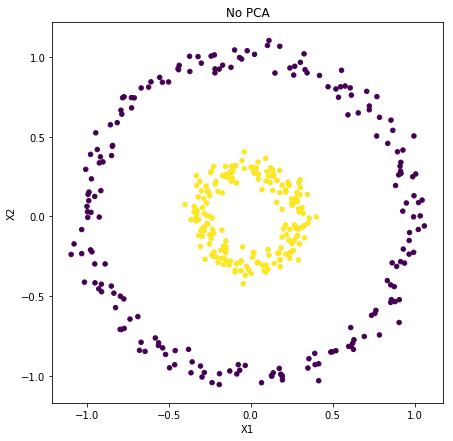

In [256]:
# define kernel for PCA
kernel = gaussian_kernel 
c = 10

# create data for testing
from sklearn.datasets import make_circles
np.random.seed(0)
X, y = make_circles(n_samples=400, factor=.3, noise=.05)

# compute Gram matrix
K = np.array([[kernel(x, y, c) for x in X] for y in X])

# plot data
plt.figure(figsize=(7,7))
plt.scatter(X[:,0], X[:,1], s= 20, c = y)
plt.title('No PCA')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

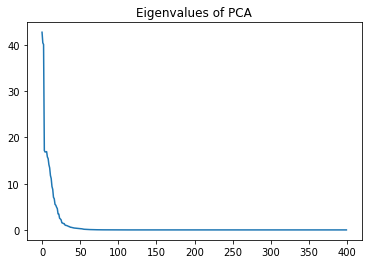

In [257]:
# compute PCA
e, v = PCA(K)
e,v = np.real(e), np.real(v)

# print eigenvalues
plt.plot(np.real(e))
plt.title("Eigenvalues of PCA")
plt.show()

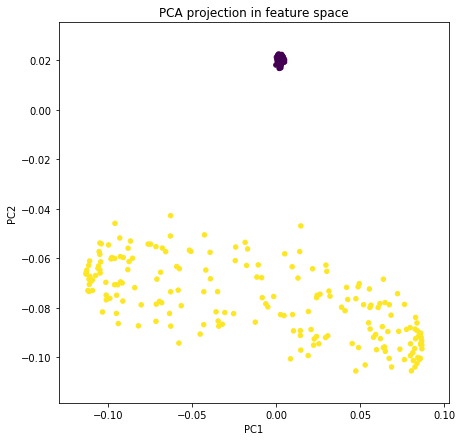

In [258]:
# plot 2D graph of the data projected on the eigenvectors associated to the 2 highest eigenvalues
n = 2
X_proj = proj(X, X, np.real(e), np.real(v), n, kernel, c)

# plot PCA
plt.figure(figsize=(7,7))
plt.scatter(X_proj[0], X_proj[1], s= 20, c = y)
plt.title('PCA projection in feature space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


Need to choose the good parameter (here gamma) for interesting kernel PCA!

#### Test with our DNA data

**Linear kernel:**

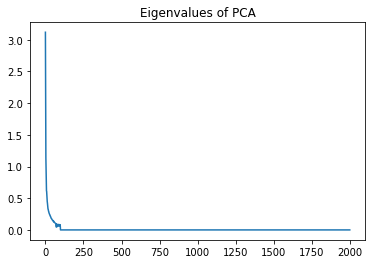

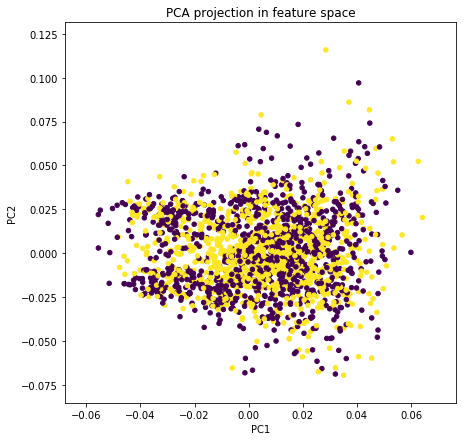

In [267]:
# choose kernel and kernel's parameter
kernel = linear_kernel
c = 200


# load data
i = 0
X_train, Y_train, X_test = load_data(i)

# compute Gram matrix
K = np.array([[kernel(x, y, c) for x in X_train] for y in X_train])

# compute PCA
e, v = PCA(K)
e,v = np.real(e), np.real(v)

# print eigenvalues
plt.plot(np.real(e))
plt.title("Eigenvalues of PCA")

# plot 2D graph of the data projected on the eigenvectors associated to the 2 highest eigenvalues
n = 2
X_proj = proj(X_train, X_train, np.real(e), np.real(v), n, kernel, c)

# plot PCA
plt.figure(figsize=(7,7))
plt.scatter(X_proj[0], X_proj[1], s= 20, c = Y_train)
plt.title('PCA projection in feature space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


**Gaussian kernel**

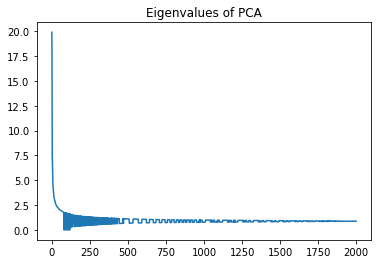

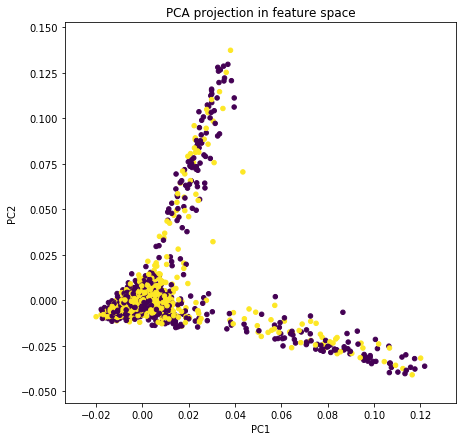

In [268]:
# choose kernel and kernel's parameter
kernel = gaussian_kernel
c = 200


# load data
i = 0
X_train, Y_train, X_test = load_data(i)

# compute Gram matrix
K = np.array([[kernel(x, y, c) for x in X_train] for y in X_train])

# compute PCA
e, v = PCA(K)
e,v = np.real(e), np.real(v)

# print eigenvalues
plt.plot(np.real(e))
plt.title("Eigenvalues of PCA")

# plot 2D graph of the data projected on the eigenvectors associated to the 2 highest eigenvalues
n = 2
X_proj = proj(X_train, X_train, np.real(e), np.real(v), n, kernel, c)

# plot PCA
plt.figure(figsize=(7,7))
plt.scatter(X_proj[0], X_proj[1], s= 20, c = Y_train)
plt.title('PCA projection in feature space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


## Biological Sequence Modeling with Convolutional Kernel Networks

In [347]:
X_train, Y_train, X_test = load_data(0, mat = False)

In [905]:
x = X_train[0]
x

'TTTTTGGAGATGGAATTTCAATCTTGTTGCCCAGGGTGGAATGCAATGGCACAATCTCTGCCTCAGCCTCCGGAGTAGCTGGGATTACAGGCATGCGCCAA'

**k-mer of x centered at position i**

In [29]:
ENCODING = {'A': [1.,0.,0.,0.],
                'C': [0.,1.,0.,0.],
                'G': [0.,0.,1.,0.],
                'T': [0.,0.,0.,1.]
               }

def P(i, x, k):
                
    if i-(k+1)//2 + 1 < 0:
        k_mer_i = x[len(x) + i-(k+1)//2 + 1:] + x[0 :  i + (k+2)//2]
    elif i + (k+2)//2 > len(x):
        k_mer_i = x[i-(k+1)//2 + 1 : ] +  x[:i + (k+2)//2 - len(x)]
    else:
        k_mer_i = x[i-(k+1)//2 + 1 :  i + (k+2)//2]
        
    # concatenate one hot encoding
    L = []
    for c in k_mer_i:
        L += ENCODING[c]
    
    return np.array(L)
    

In [30]:
def K0(z1, z2, k, σ):
    return k*np.exp(-(1/(2*k*(σ**2)))*np.linalg.norm(z1-z2)**2)

def K1(z1, z2, k, σ):
    return k*np.exp((1/(σ**2))*(z1.dot(z2)/k-1))

In [31]:
def conv_kernel(x,y,k, σ):
    mx = len(x)
    my = len(y)    
    Px = np.array([P(i,x,k) for i in range(mx)])
    Py = np.array([P(i,y,k) for i in range(mx)])
    PxPyt = Px.dot(Py.T)/k
    s = k*np.exp((1/(σ**2))*(PxPyt-1))
        
    return np.sum(s)/(mx*my)

In [38]:
k =  5
σ = 1
def bio_kernel(x,y,c):
    return conv_kernel(x,y,k,σ)

In [ ]:
results = np.zeros(3000)

kernel = bio_kernel

γ = 400
λ = 1e-5
len_val =  400
len_train = 2000 - len_val

for i in range(len(FILES)):
    X_train, Y_train, X_test = load_data(i, mat=False)
    X_val = X_train[len_train:]
    Y_val = Y_train[len_train:]
    X_train = X_train[:len_train]
    Y_train = Y_train[:len_train]
    clf = SVM(γ, λ, kernel)
    clf.fit(X_train, Y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_val = clf.predict(X_val)
    y_pred_test = clf.predict(X_test)
    
    score_train = clf.score(y_pred_train, Y_train)
    score_val = clf.score(y_pred_val, Y_val)
    results[i*1000:i*1000 + 1000] = y_pred_test
    print(f"Accuracy on train set / val set {i} : {score_train} / {score_val}")

## Save results

In [45]:
def save_results(filename, results):
    """
    Save results in a csv file
    
    Parameters
    -----------
    - filename : string
        Name of the file to be saved under the ``results`` folder
        
    - results : numpy.array
        Resulting array (0 and 1's)
    """
    
    assert filename.endswith(".csv"), "this is not a csv extension!"
    # Convert results to int
    results = results.astype("int")
    
    with open(os.path.join(RESULT_DIR, filename), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')

        # Write header
        writer.writerow(["Id", "Bound"]) 
        assert len(results) == 3000, "There is not 3000 predictions"
        # Write results
        for i in range(len(results)):
            writer.writerow([i, results[i]])

In [50]:
# Test the save results function
save_results("results5.csv", results)